<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/elegy_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Elegy

This is slightly modified from 
https://poets-ai.github.io/elegy/getting-started/high-level-api/
and 
https://poets-ai.github.io/elegy/getting-started/low-level-api/



In this tutorial we will explore the basic features of **Elegy**. If you are a Keras user you should feel at home, if you are currently learning JAX things will appear much more streamlined. To get started you will first need to install the following dependencies:

In [1]:
%%capture
!pip install git+https://github.com/deepmind/dm-haiku
#!pip install -q clu ml-collections git+https://github.com/google/flax

In [4]:
%%capture
! pip install --upgrade pip
! pip install elegy datasets matplotlib


## Loading the Data
In this tutorial we will train a Neural Network on the MNIST dataset, for this we will first need to download and load the data into memory. Here we will use the `datasets` library to load the dataset.

In [6]:
from datasets.load import load_dataset

dataset = load_dataset("mnist")
dataset.set_format("np")
X_train = dataset["train"]["image"]
y_train = dataset["train"]["label"]
X_test = dataset["test"]["image"]
y_test = dataset["test"]["label"]

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/989 [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/9.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset mnist downloaded and prepared to /root/.cache/huggingface/datasets/mnist/mnist/1.0.0/5064c25e57a1678f700d2dc798ffe8a6d519405cca7d33670fffda477857a994. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

X_train: (60000, 28, 28) int64
y_train: (60000,) int64
X_test: (10000, 28, 28) int64
y_test: (10000,) int64


## Defining the Architecture
The first thing we need to do is define our model's architecture inside a `Module`, to do this we just create a class that inherites from `Module` and implement a `__call__` method. In this example we will create a simple 2 layer MLP: 

In [7]:
import jax.numpy as jnp
import jax

import elegy as eg


class MLP(eg.Module):
    def __init__(self, n1: int, n2: int):
        self.n1 = n1
        self.n2 = n2

    @eg.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        x = x.astype(jnp.float32) / 255.0
        x = eg.nn.Flatten()(x)
        # first layers
        x = eg.nn.Linear(self.n1)(x)
        x = jax.nn.relu(x)
        # first layers
        x = eg.nn.Linear(self.n2)(x)
        x = jax.nn.relu(x)
        # output layer
        x = eg.nn.Linear(10)(x)

        return x

This code should feel familiar to most Keras / PyTorch users, the main difference is that we are using the `@compact` decorator to define submodules inline (e.g. Linear) inline, this tends to produce much shorter and readable code.

## Creating the Model

Now that we have this module we can create an Elegy `Model` which is Elegy's central API:

In [8]:
import optax

model = eg.Model(
    module=MLP(n1=300, n2=100),
    loss=[
        eg.losses.Crossentropy(),
        eg.regularizers.L2(l=1e-4),
    ],
    metrics=eg.metrics.Accuracy(),
    optimizer=optax.adam(1e-3),
)

If you are a Keras user this code should look familiar, main differences are:

* You need to pass a `module` with the architecture.
* `loss` and `metrics` are a bit more flexible in that they do not need to match the label's structure.
* There is no `compile` step, all its done in the constructor.
* For the `optimizer` you can use any `optax` optimizer. 

As in Keras, you can get a rich description of the model by calling `Model.summary` with a sample input:

In [9]:
model.summary(X_train[:64])

┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module    ┃ params         ┃ inputs         ┃ outputs        ┃ Parameter       ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ *        │ MLP()     │                │ (64, 28, 28)   │ (64, 10)       │                 │
│          │           │                │ int32          │ float32        │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .flatten │ Flatten() │                │ (64, 28, 28)   │ (64, 784)      │                 │
│          │           │                │ float32        │ float32        │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .linear  │ Linear()  │ bias:          │ (64, 784)      │ (64, 300)      │ 235,500         │
│          │           │ Parameter(300) │ float32        │ float32        │ 942.0KB         │
│          │           │ float32        │                │                │                 │
│          │           │ kernel:        │                │                │                 │
│          │           │ Parameter(784, │                │                │                 │
│          │           │ 300)  float32  │                │                │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .linear2 │ Linear()  │ bias:          │ (64, 300)      │ (64, 100)      │ 30,100          │
│          │           │ Parameter(100) │ float32        │ float32        │ 120.4KB         │
│          │           │ float32        │                │                │                 │
│          │           │ kernel:        │                │                │                 │
│          │           │ Parameter(300, │                │                │                 │
│          │           │ 100)  float32  │                │                │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .linear3 │ Linear()  │ bias:          │ (64, 100)      │ (64, 10)       │ 1,010    4.0KB  │
│          │           │ Parameter(10)  │ float32        │ float32        │                 │
│          │           │ float32        │                │                │                 │
│          │           │ kernel:        │                │                │                 │
│          │           │ Parameter(100, │                │                │                 │
│          │           │ 10)   float32  │                │                │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│          │           │                │                │         Total: │ 266,610  1.1MB  │
└──────────┴───────────┴────────────────┴────────────────┴────────────────┴─────────────────┘
                                                                                             
                              Total Parameters: 266,610  1.1MB                               

## Training the Model
We are now ready to pass our model some data to start training, like in Keras this is done via the `fit` method which contains more or less the same signature. Elegy support a variety of input data sources like Tensorflow Dataset, Pytorch DataLoader, Elegy DataLoader, and Python Generators, check out the guide on Data Sources for more information. 

The following code will train our model for `10` epochs while limiting each epoch to `200` steps and using a batch size of `64`:

In [11]:
%%time

history = model.fit(
    inputs=X_train,
    labels=y_train,
    epochs=10,
    steps_per_epoch=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=3,
    callbacks=[eg.callbacks.ModelCheckpoint("models/high-level", save_best_only=True)],
)

[0]Step/Epoch | [1]Time | [2]accuracy | [3]crossentropy_loss | [4]l2_loss | [5]loss
[6]val_accuracy | [7]val_crossentropy_loss | [8]val_l2_loss | [9]val_loss
                                                                                  
###[0]###|###[1]###|##[2]##|##[3]##|##[4]##|##[5]##|##[6]##|##[7]##|##[8]##|##[9]##
       0 |    1.0s | 0.980 | 0.067 | 0.046 | 0.113 | 0.970 | 0.095 | 0.047 | 0.142
       1 |    0.7s | 0.978 | 0.072 | 0.047 | 0.119 | 0.973 | 0.085 | 0.047 | 0.132
       2 |    0.7s | 0.979 | 0.068 | 0.048 | 0.115 | 0.977 | 0.075 | 0.048 | 0.123
       3 |    0.7s | 0.980 | 0.065 | 0.048 | 0.113 | 0.975 | 0.082 | 0.048 | 0.130
       4 |    0.7s | 0.978 | 0.066 | 0.048 | 0.114 | 0.977 | 0.071 | 0.049 | 0.119
       5 |    0.7s | 0.984 | 0.051 | 0.049 | 0.100 | 0.972 | 0.091 | 0.049 | 0.141
       6 |    0.7s | 0.981 | 0.062 | 0.049 | 0.111 | 0.972 | 0.088 | 0.049 | 0.138
       7 |    0.7s | 0.982 | 0.057 | 0.050 | 0.107 | 0.977 | 0.073 | 0.050 | 0.123
       8 | 

The `ModelCheckpoint` callback will periodically save the model in a folder called `"models/high-level"`, we will use it later.

`fit` returns a `History` object which of the losses and metrics during training which we can visualize.

## Plotting learning curves

In [13]:
print(history)
print(history.history)
print(history.history.keys())

{'accuracy': [DeviceArray(0.97875, dtype=float32), DeviceArray(0.9777343, dtype=float32), DeviceArray(0.97882813, dtype=float32), DeviceArray(0.9797656, dtype=float32), DeviceArray(0.9784077, dtype=float32), DeviceArray(0.98375, dtype=float32), DeviceArray(0.98085934, dtype=float32), DeviceArray(0.9819531, dtype=float32), DeviceArray(0.98335934, dtype=float32), DeviceArray(0.9867305, dtype=float32)], 'crossentropy_loss': [DeviceArray(0.07138356, dtype=float32), DeviceArray(0.07160068, dtype=float32), DeviceArray(0.06785905, dtype=float32), DeviceArray(0.06543601, dtype=float32), DeviceArray(0.06590888, dtype=float32), DeviceArray(0.05132652, dtype=float32), DeviceArray(0.06165808, dtype=float32), DeviceArray(0.05692255, dtype=float32), DeviceArray(0.05551724, dtype=float32), DeviceArray(0.04438237, dtype=float32)], 'l2_loss': [DeviceArray(0.04622991, dtype=float32), DeviceArray(0.04692444, dtype=float32), DeviceArray(0.04753873, dtype=float32), DeviceArray(0.04794404, dtype=float32), D

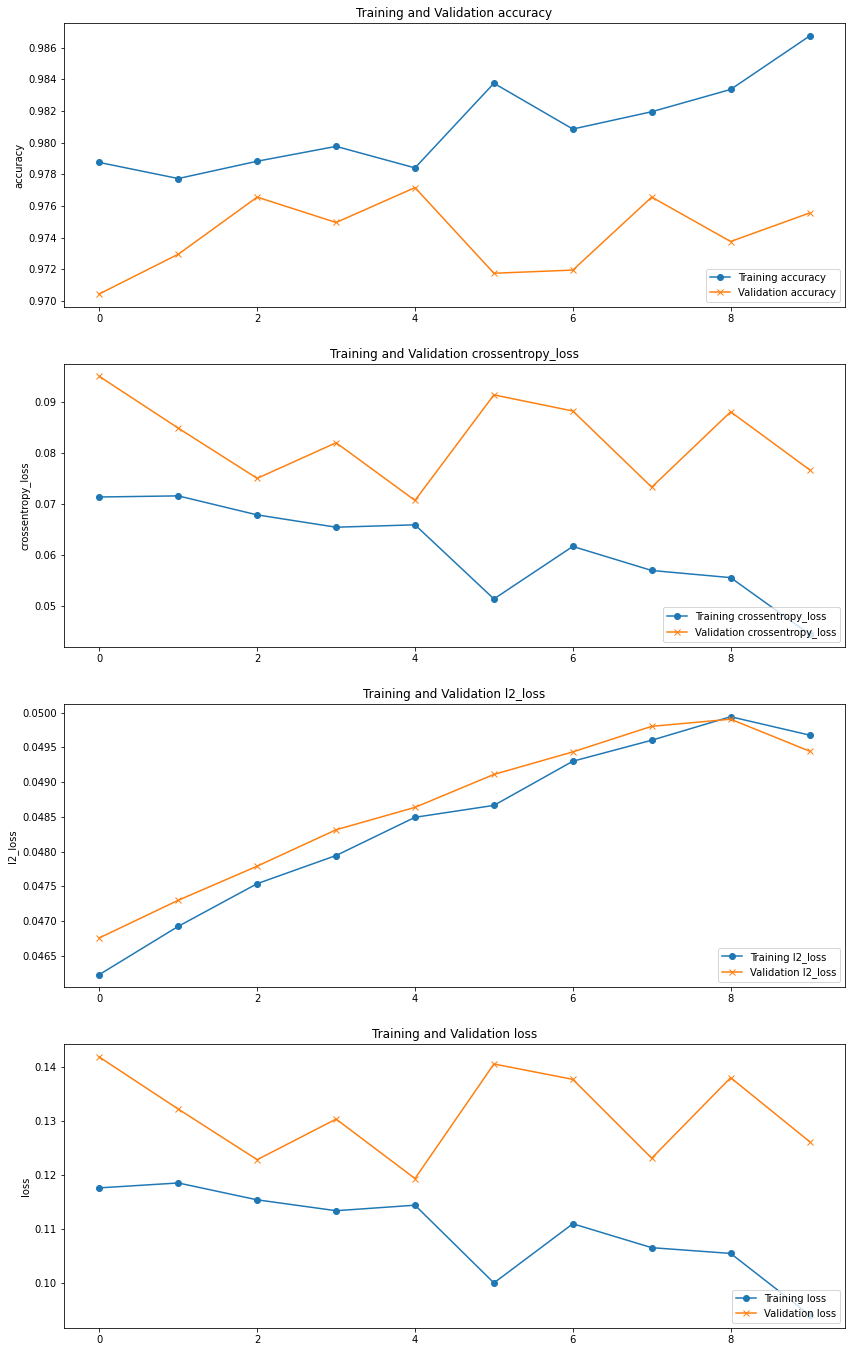

In [14]:
import matplotlib.pyplot as plt


def plot_history(history):
    n_plots = len(history.history.keys()) // 2
    plt.figure(figsize=(14, 24))

    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, "o-", label=f"Training {key}")
        plt.plot(val_metric, "x-", label=f"Validation {key}")
        plt.legend(loc="lower right")
        plt.ylabel(key)
        plt.title(f"Training and Validation {key}")
    plt.show()


plot_history(history)

In [15]:
ev = model.evaluate(x=X_test, y=y_test)
print(ev)

313/313 [==============================] - 3s 11ms/step - accuracy: 0.9716 - crossentropy_loss: 0.0926 - l2_loss: 0.0494 - loss: 0.1421
{'accuracy': DeviceArray(0.97560006, dtype=float32), 'crossentropy_loss': DeviceArray(0.07650337, dtype=float32), 'l2_loss': DeviceArray(0.04944682, dtype=float32), 'loss': DeviceArray(0.1259502, dtype=float32), 'size': 32}


## Generating Predictions

Having our trained model we can now get some samples from the test set and generate some predictions. Lets select `9` random images and call `.predict`:

In [16]:
import numpy as np

idxs = np.random.randint(0, len(X_test), size=(9,))
x_sample = X_test[idxs]

y_pred = model.predict(x=x_sample)

In [17]:
print(y_pred.shape)

(9, 10)


Easy right? Finally lets plot the results to see if they are accurate.

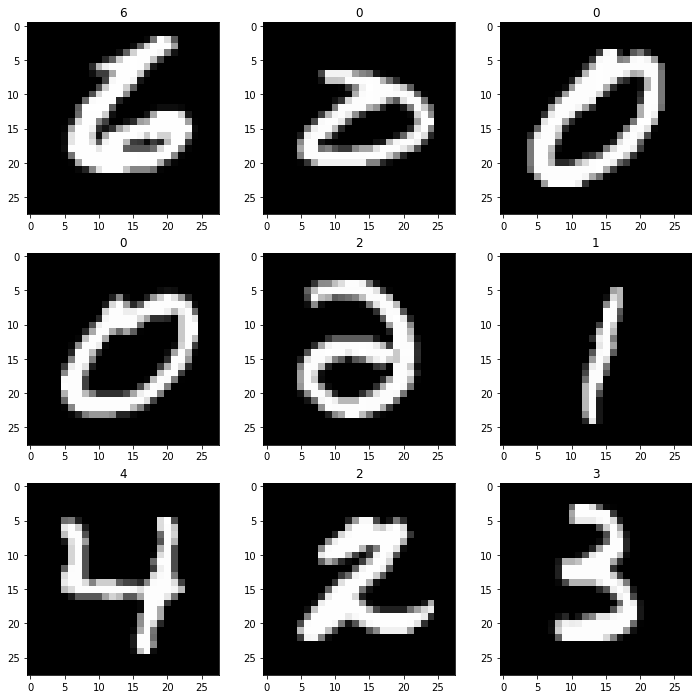

In [18]:
plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)

        plt.title(f"{np.argmax(y_pred[k])}")
        plt.imshow(x_sample[k], cmap="gray")



## Serialization
To serialize the `Model` you can use the `model.save(...)`, this will create a folder with some files that contain the model's code plus all parameters and states.

In [19]:
model.save("mymodel")

In [20]:
!ls

models	mymodel  sample_data


In [21]:
!ls mymodel

model.pkl




However since we had previously used the `ModelCheckpoint` callback we can load it using `elegy.load`. Lets get a new model reference containing the same weights and call its `evaluate` method to verify it loaded correctly:

In [22]:
!ls models

high-level


In [23]:
!ls models/high-level

model.pkl


In [24]:
# current model reference
print("current model id:", id(model))

model.evaluate(x=X_test, y=y_test)

model_old = model

# load model from disk
model = eg.load("models/high-level")

# new model reference
print("new model id:    ", id(model))

# check that it works!
model.evaluate(x=X_test, y=y_test)

current model id: 140630126070032
313/313 [==============================] - 1s 4ms/step - accuracy: 0.9716 - crossentropy_loss: 0.0926 - l2_loss: 0.0494 - loss: 0.1421
new model id:     140630642950096
313/313 [==============================] - 3s 9ms/step - accuracy: 0.9722 - crossentropy_loss: 0.0852 - l2_loss: 0.0486 - loss: 0.1339


{'accuracy': DeviceArray(0.97720003, dtype=float32),
 'crossentropy_loss': DeviceArray(0.07048728, dtype=float32),
 'l2_loss': DeviceArray(0.04863739, dtype=float32),
 'loss': DeviceArray(0.11912467, dtype=float32),
 'size': 32}


You can also serialize your Elegy Model as a TensorFlow SavedModel which is portable to many platforms many platforms and services, to do this you can use the `saved_model` method. `saved_model` will convert the function that creates the predictions for your Model (`pred_step`) in Jax to a TensorFlow version via `jax2tf` and then serialize it to disk.

The function `saved_model` accepts a sample to infer the shapes, the path where the model will be saved at, and a list of batch sizes for the different signatures it accepts. Due to some current limitations in Jax it is not possible to create signatures with dynamic dimensions so you must specify a couple which might fit you needs. 

In [25]:
model.saved_model(x_sample, "saved-models/high-level")

INFO:tensorflow:Assets written to: saved-models/high-level/assets


INFO:tensorflow:Assets written to: saved-models/high-level/assets


In [26]:
!ls saved-models/high-level

assets	saved_model.pb	variables


We can test our saved model by loading it with TensorFlow and generating a couple of predictions as we did previously:

In [28]:
import tensorflow as tf

saved_model = tf.saved_model.load("saved-models/high-level")

y_pred_tf = saved_model(x_sample.astype(np.int32))

plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)

        plt.title(f"{np.argmax(y_pred_tf[k])}")
        plt.imshow(x_sample[k], cmap="gray")

ResourceExhaustedError: ignored

## Distributed training

To parallelize training and inference using pmap on a mulit-core TPU you just need to add
```
model = model.distributed()
```
after creating the model.
For an example, try running https://github.com/probml/pyprobml/blob/master/scripts/mnist_elegy_distributed.py on a TPU VM v3-8.
In colab,  there will not be any speedup, since there is only 1 GPU. (I have not tried TPU mode in colab.)




## Low-level API

### Introduction




The low-level API lets you redefine what happens during the various stages of training, evaluation and inference by implementing some methods in a custom class. Here is the list of methods you can define along with the high-level method that uses it:

| Low-level Method | High-level Method | 
| :- | :- |
| `pred_step` | `predict` |
| `test_step` | `evaluate` |
| `grad_step` | NA |
| `train_step` | `fit` |

Check out the guides on the low-level API for more information.

In this tutorial we are going to implement Linear Classifier using pure Jax by overriding`pred_step` which defines the forward pass and `test_step` which defines loss and metrics of our model. 

`pred_step` returns a tuple with:
* `y_pred`: predictions of the model
* `states`: a `elegy.States` namedtuple that contains the states for thing like network trainable parameter, network states, metrics states, optimizer states, rng state.

`test_step` returns a tuple with:
* `loss`: the scalar loss use to calculate the gradient
* `logs`: a dictionary with the logs to be reported during training
* `states`: a `elegy.States` namedtuple that contains the states for thing like network trainable parameter, network states, metrics states, optimizer states, rng state.

Since Jax is functional you will find that low-level API is very explicit with state management, that is, you always get the currrent state as input and you return the new state as output. Lets define `test_step` to make things clearer:

### Linear classifier

In [29]:
import jax
import numpy as np
import jax.numpy as jnp
import typing as tp
import elegy as eg

M = tp.TypeVar("M", bound=eg.Model)


class LinearClassifier(eg.Model):
    w: jnp.ndarray = eg.Parameter.node()
    b: jnp.ndarray = eg.Parameter.node()

    def __init__(
        self,
        features_out: int,
        loss: tp.Any = None,
        metrics: tp.Any = None,
        optimizer=None,
        seed: int = 42,
        eager: bool = False,
    ):
        self.features_out = features_out
        super().__init__(
            loss=loss,
            metrics=metrics,
            optimizer=optimizer,
            seed=seed,
            eager=eager,
        )

    def init_step(self: M, key: jnp.ndarray, inputs: jnp.ndarray) -> M:
        features_in = np.prod(inputs.shape[1:])

        self.w = jax.random.uniform(
            key,
            shape=[
                features_in,
                self.features_out,
            ],
        )
        self.b = jnp.zeros([self.features_out])

        assert self.optimizer is not None
        self.optimizer = self.optimizer.init(self)

        return self

    def pred_step(self: M, inputs: tp.Any) -> eg.PredStepOutput[M]:
        # flatten + scale
        inputs = jnp.reshape(inputs, (inputs.shape[0], -1)) / 255

        # linear
        logits = jnp.dot(inputs, self.w) + self.b

        return logits, self

    def test_step(
        self: M,
        inputs,
        labels,
    ) -> eg.TestStepOutput[M]:
        model = self

        # forward
        logits, model = model.pred_step(inputs)

        # crossentropy loss
        target = jax.nn.one_hot(labels["target"], self.features_out)
        loss = jnp.mean(-jnp.sum(target * jax.nn.log_softmax(logits), axis=-1))

        # metrics
        logs = dict(
            acc=jnp.mean(jnp.argmax(logits, axis=-1) == labels["target"]),
            loss=loss,
        )

        return loss, logs, model

Notice the following:
* We define a bunch of arguments with specific names, Elegy uses Dependency Injection so you can just request what you need.
* `initializing` tells us if we should initialize our parameters or not, here we are directly creating them ourselves but if you use a Module system you can conditionally call its `init` method here.
* Our model is defined by a simple linear function.
* Defined a simple crossentropy loss and an accuracy metric, we added both the the logs.
* We set the updated `States.net_params` with the `w` and `b` parameters so we get them as an input on the next run after they are initialized.
* `States.update` offers a clean way inmutably update the states without having to copy all fields to a new States structure.

Remember `test_step` only defines what happens during `evaluate`, however, `Model`'s default implementation has a structure where on method is defined in terms of another:

```
pred_step ⬅ test_step ⬅ grad_step ⬅ train_step
```

Because of this, we get the `train_step` / `fit` for free if we just pass an optimizer to the the constructor as we are going to do next:

### Training

In [30]:
import optax

model = LinearClassifier(features_out=10, optimizer=optax.adam(1e-3))

In [31]:
history = model.fit(
    inputs=X_train,
    labels=y_train,
    epochs=10,
    steps_per_epoch=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[eg.callbacks.ModelCheckpoint("models/low-level", save_best_only=True)],
)

Epoch 1/10
200/200 [==============================] - 2s 9ms/step - acc: 0.4387 - loss: 1.9352 - val_acc: 0.5781 - val_loss: 1.4558
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - acc: 0.7656 - loss: 0.5386 - val_acc: 0.7656 - val_loss: 0.9839
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - acc: 0.8594 - loss: 0.4755 - val_acc: 0.7969 - val_loss: 0.8447
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - acc: 0.9062 - loss: 0.3554 - val_acc: 0.8281 - val_loss: 0.7401
Epoch 5/10
199/200 [============================>.] - 0s 2ms/step - acc: 0.8594 - loss: 0.4128 - val_acc: 0.8438 - val_loss: 0.6882
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - acc: 0.8750 - loss: 0.3504 - val_acc: 0.8281 - val_loss: 0.6493
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - acc: 0.9219 - loss: 0.4800 - val_acc: 0.8281 - val_loss: 0.5941
Epoch 8/10
200/200 [==============================] - 0s 2ms/step - acc: 0.9

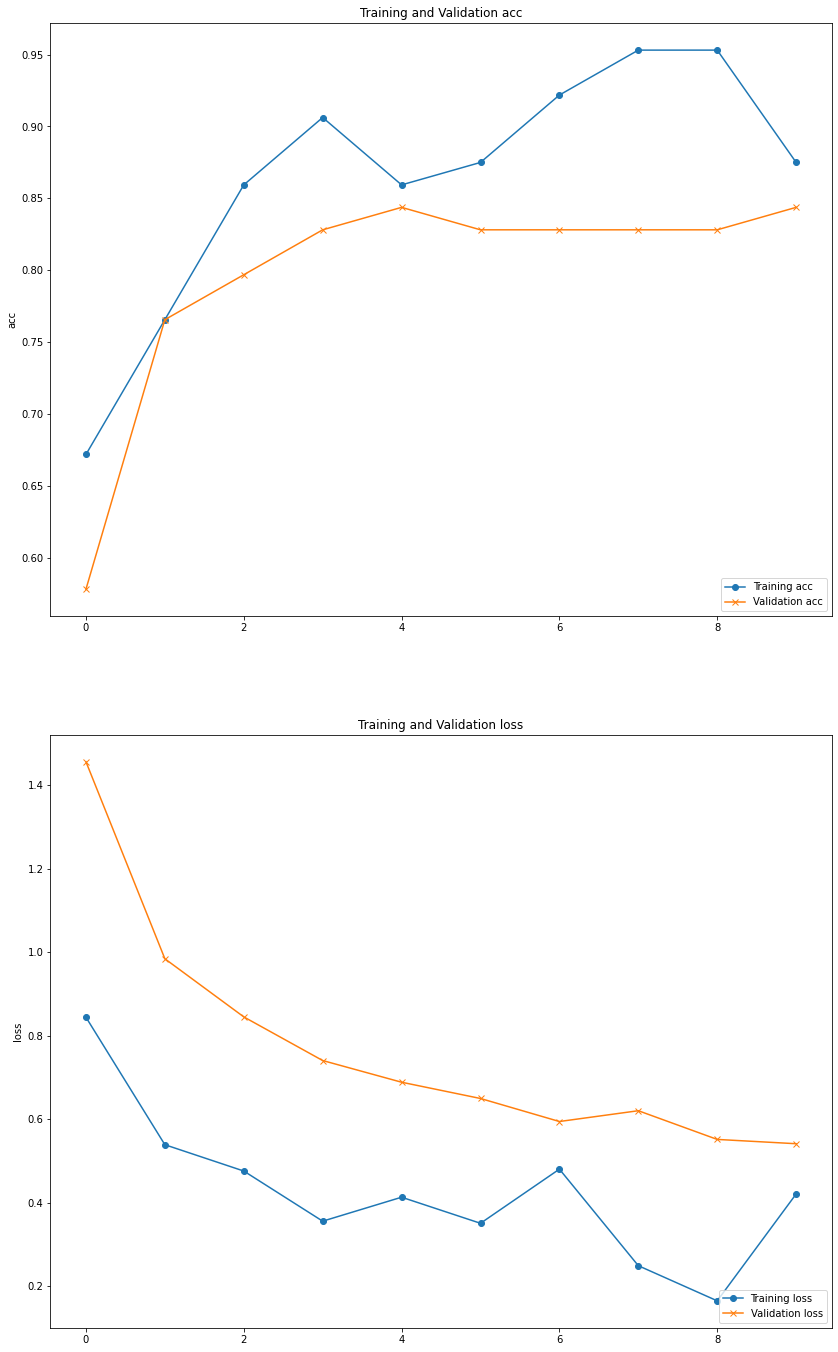

In [33]:
import matplotlib.pyplot as plt


def plot_history(history):
    n_plots = len(history.history.keys()) // 2
    plt.figure(figsize=(14, 24))

    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, "o-", label=f"Training {key}")
        plt.plot(val_metric, "x-", label=f"Validation {key}")
        plt.legend(loc="lower right")
        plt.ylabel(key)
        plt.title(f"Training and Validation {key}")
    plt.show()


plot_history(history)

Notice that the logs are very noisy, this is because for this example we didn't use cummulative metrics so the reported value is just the value for the last batch of that epoch, not the value for the entire epoch. To fix this we could use some of the modules in `elegy.metrics`.